# An introduction to [`nilearn`](http://nilearn.github.io)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from nilearn import datasets

os.environ["NILEARN_SHARED_DATA"] = "~/shared/data/nilearn_data"
datasets.get_data_dirs()

['~/shared/data/nilearn_data', '/Users/emdupre/nilearn_data']

In this tutorial, we'll see how the Python library `nilearn` allows us to easily perform machine learning and statistical learning analyses with neuroimaging data, specifically MRI and fMRI.

```{note}
You may notice that the name `nilearn` is reminiscent of [`scikit-learn`](https://scikit-learn.org),
a popular Python library for machine learning.
This is no accident!
Nilearn and scikit-learn were created by overlapping teams,
and nilearn is designed to bring machine **LEARN**ing to NeuroImaging (**NI**) data.
```

## Neuroimaging data

While common machine learning pipelines assume tabular data, neuroimaging data does not have this structure.
Instead, it has [both spatial and temporal dependencies](https://www.nature.com/articles/s41593-023-01299-3) between successive data points.
That is, knowing _where_ and _when_ something was measured tells you information about the surrounding data points.

We also know that neuroimaging data contains a lot of signal that's _not_ blood-oxygen-level dependent (BOLD), such as head motion.
Since we don't think that these other noise sources are related to neuronal firing,
we often need to consider how we can make sure that our analyses are not driven by these noise sources.

These are all considerations that most machine learning software libraries are not designed to deal with!
Nilearn therefore plays a crucial role in bringing machine learning concepts to the neuroimaging domain.

To get a sense of the problem, the quickest method is to just look at some data.
You may have your own data locally that you'd like to work with.
Nilearn also provides access to several neuroimaging data sets and atlases (we'll talk about these a bit later).

These data sets (and atlases) are only accessible because research groups chose to make their collected data publicly available.
We owe them a huge thank you for this!
The data set we'll use today was originally collected by [Rebecca Saxe](https://mcgovern.mit.edu/profile/rebecca-saxe/)'s group at MIT and hosted on [OpenNeuro](https://openneuro.org/datasets/ds000228/versions/1.1.0).

The nilearn team preprocessed the data set with [fMRIPrep](https://fmriprep.readthedocs.io) and downsampled it to a lower resolution,
so it'd be easier to work with.
We can learn a lot about this data set directly [from the Nilearn documentation](https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_development_fmri.html).
For example, we can see that this data set contains over 150 children and adults watching a short Pixar film.
Let's download the first 30 participants.

In [3]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)

[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri
[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri/development_fmri
[fetch_development_fmri] Dataset found in /Users/emdupre/nilearn_data/development_fmri/development_fmri


Now, this `development_dataset` object has several attributes which provide access to the relevant information.
For example, `development_dataset.phenotypic` provides access to information about the participants, such as whether they were children or adults.
We can use `development_dataset.func` to access the functional MRI (fMRI) data.

Let's use the [nibabel library](https://nipy.org/nibabel/) to learn a little bit about this data:

In [4]:
import nibabel as nib

img = nib.load(development_dataset.func[0])
img.shape

(50, 59, 50, 168)

This means that there are 168 volumes, each with a 3D structure of (50, 59, 50).

## Getting into the data: subsetting and viewing

Nilearn also provides many methods for plotting this kind of data.
For example, we can use [`nilearn.plotting.view_img`](https://nilearn.github.io/modules/generated/nilearn.plotting.view_img.html) to launch at interactive viewer.
Because each fMRI run is a 4D time series (three spatial dimensions plus time),
we'll also need to subset the data when we plot it, so that we can look at a single 3D image.
Nilearn provides (at least) two ways to do this: with [`nilearn.image.index_img`](https://nilearn.github.io/modules/generated/nilearn.image.index_img.html),
which allows us to index a particular frame--or several frames--of a time series,
and [`nilearn.image.mean_img`](https://nilearn.github.io/modules/generated/nilearn.image.mean_img.html),
which allows us to take the mean 3D image over time.

Putting these together, we can interatively view the mean image of the first participant using:


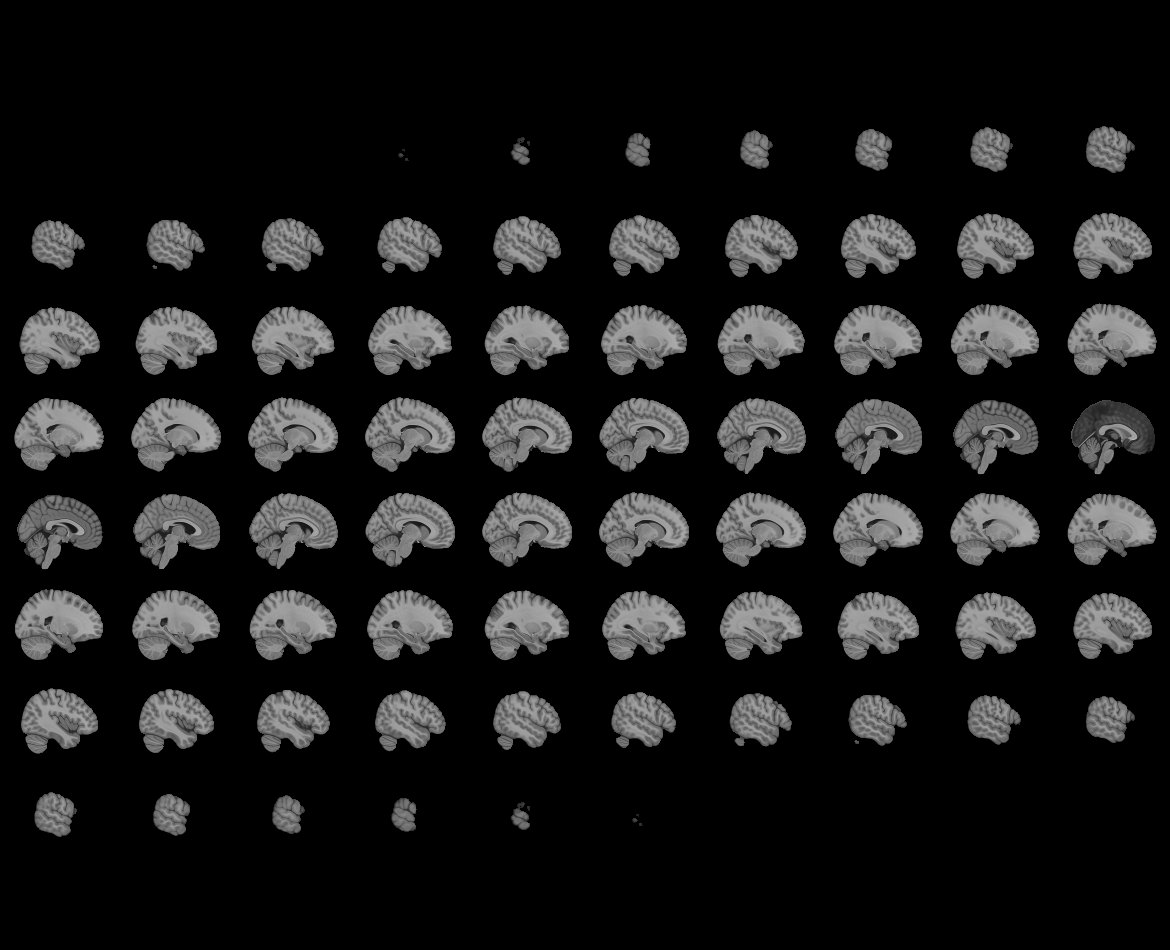
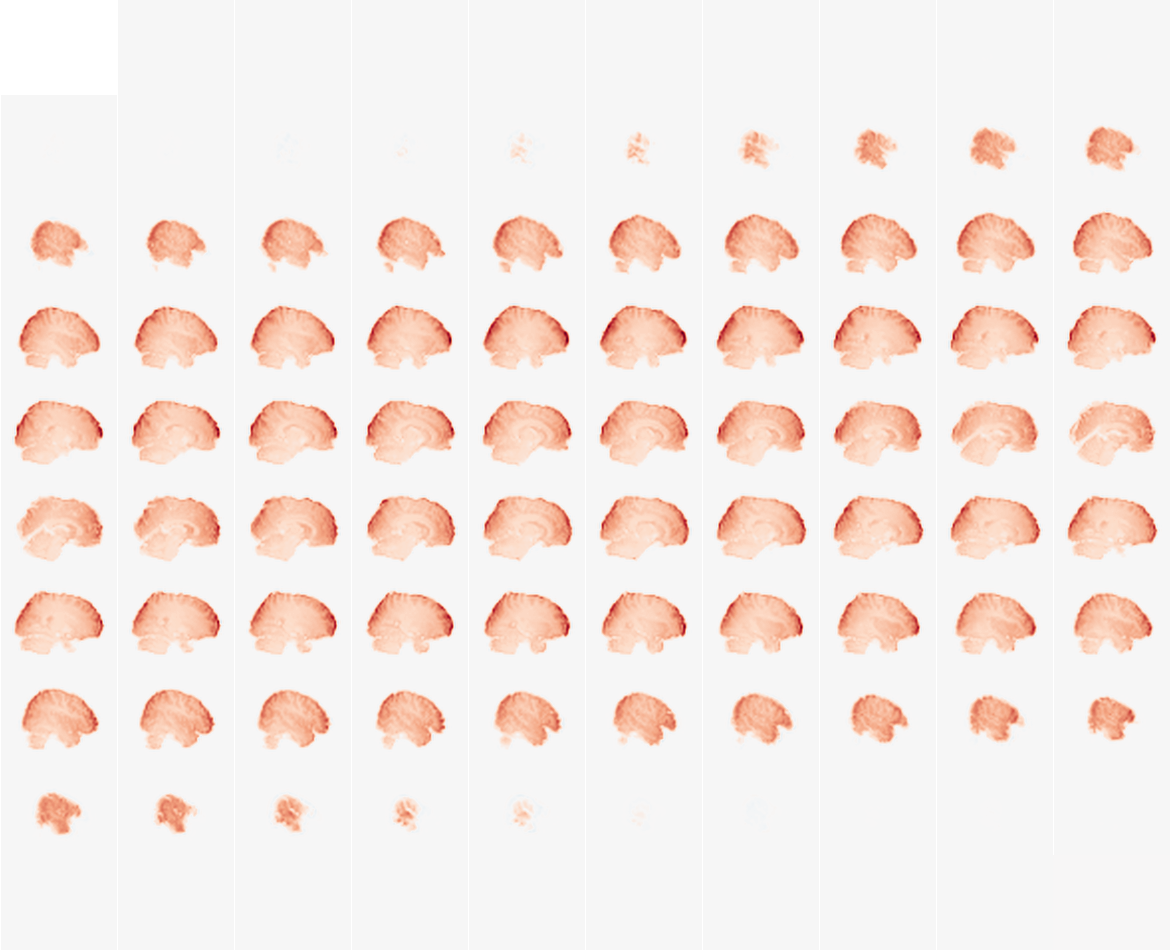

In [5]:
import matplotlib.pyplot as plt
from nilearn import image
from nilearn import plotting

mean_image = image.mean_img(development_dataset.func[0])
plotting.view_img(mean_image, threshold=None)

## Extracting signal from fMRI volumes

As you can see, this data is decidedly not tabular!
What we'd like is to extract and transform meaningful features from this data,
and store it in a format that we can easily work with.
Importantly, we _could_ work with the full time series directly.
But we often want to reduce the dimensionality of our data in a structured way.
That is, we may only want to consider signal within certain learned or pre-defined regions of interest (ROIs),
and when taking into account known sources of noise.
To do this, we'll use nilearn's Masker objects.
What are the masker objects ?
First, let's think about what masking fMRI data is doing:

```{figure} ../images/masking.jpg
---
height: 350px
name: masking
---
Masking fMRI data.
```

Essentially, we can imagine overlaying a 3D grid on an image.
Then, our mask tells us which cubes or “voxels” (like 3D pixels) to sample from.
Since our Nifti images are 4D files, we can’t overlay a single grid –
instead, we use a series of 3D grids (one for each volume in the 4D file),
so we can get a measurement for each voxel at each timepoint.

Masker objects allow us to apply these masks!
To start, we need to define a mask (or masks) that we'd like to apply.
This could correspond to one or many regions of interest.
Nilearn provides methods to define your own functional parcellation (using clustering algorithms such as _k-means_),
and it also provides access to other atlases that have previously been defined by researchers.

## Choosing regions of interest

In this tutorial,
we'll use the MSDL (multi-subject dictionary learning; {cite}`Varoquaux_2011`) atlas,
which defines a set of _probabilistic_ ROIs across the brain.

In [6]:
import numpy as np

msdl_atlas = datasets.fetch_atlas_msdl()

msdl_coords = msdl_atlas.region_coords
n_regions = len(msdl_coords)

print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')

[fetch_atlas_msdl] Dataset found in /Users/emdupre/nilearn_data/msdl_atlas
MSDL has 39 ROIs, part of the following networks :
['Ant IPS' 'Aud' 'Basal' 'Cereb' 'Cing-Ins' 'D Att' 'DMN' 'Dors PCC'
 'L V Att' 'Language' 'Motor' 'Occ post' 'R V Att' 'Salience' 'Striate'
 'Temporal' 'Vis Sec'].


Nilearn ships with several atlases commonly used in the field,
including the Schaefer atlas and the Harvard-Oxford atlas.

It also provides us with easy ways to view these atlases directly.
Because MSDL is a probabilistic atlas, we can view it using:

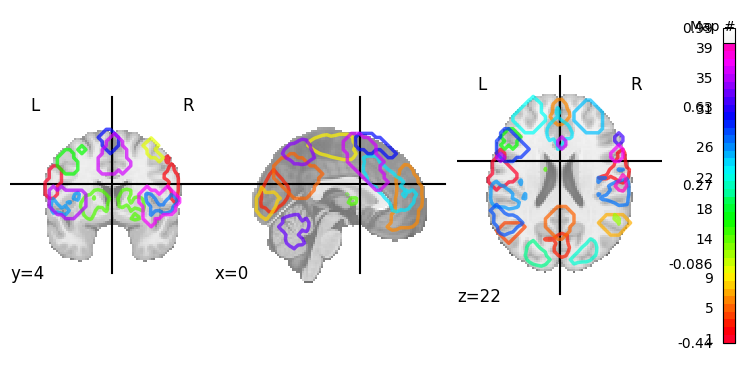

In [7]:
plotting.plot_prob_atlas(msdl_atlas.maps)

## A quick side-note on the NiftiMasker zoo

We'd like to supply these ROIs to a Masker object.
All Masker objects share the same basic structure and functionality,
but each is designed to work with a different kind of ROI.

The canonical [`nilearn.maskers.NiftiMasker`](https://nilearn.github.io/modules/generated/nilearn.maskers.NiftiMasker.html) works well if we want to apply a single mask to the data,
like a single region of interest.

But what if we actually have several ROIs that we'd like to apply to the data all at once?
If these ROIs are non-overlapping,
as in "hard" or deterministic parcellations,
then we can use [`nilearn.maskers.NiftiLabelsMasker`](https://nilearn.github.io/modules/generated/nilearn.maskers.NiftiLabelsMasker.html).
Because we're working with "soft" or probabilistic ROIs,
we can instead supply these ROIs to [`nilearn.maskers.NiftiMapsMasker`](https://nilearn.github.io/modules/generated/nilearn.maskers.NiftiMapsMasker.html).

For a full list of the available Masker objects,
see [the Nilearn documentation](https://nilearn.github.io/modules/reference.html#module-nilearn.maskers).

## Applying a Masker object

We can supply our MSDL atlas-defined ROIs to the `NiftiMapsMasker` object,
along with resampling, filtering, and detrending parameters.

In [8]:
from nilearn import maskers

masker = maskers.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()

One thing you might notice from the above code is that immediately after defining the masker object,
we call the `.fit` method on it.
This method may look familiar if you've previously worked with scikit-learn estimators!

You'll note that we're not supplying any data to this `.fit` method;
that's because we're fitting the Masker to the provided ROIs, rather than to our data.

## Dimensions, dimensions

We can use this fitted masker to transform our data.

In [9]:
roi_time_series = masker.transform(development_dataset.func[0])
roi_time_series.shape

(168, 39)

If you'll remember, when we first looked at the data its original dimensions were (50, 59, 50, 168).
Now, it has a shape of (168, 39).
What happened?!

Rather than providing information on every voxel within our original 3D grid,
we're now only considering those voxels that fall in our 39 regions of interest provided by the MSDL atlas and aggregating across voxels within those ROIS.
This reduces each 3D volume from a dimensionality of (50, 59, 50) to just 39,
for our 39 provided ROIs.

You'll also see that the "dimensions flipped;"
that is, that we've transposed the matrix such that time is now the first rather than second dimension.
This follows the scikit-learn convention that rows in a data matrix are _samples_,
and columns in a data matrix are _features_.

```{figure} ../images/samples-features.png
---
height: 250px
name: samples-features
---
The scikit-learn conventions for feature and target matrices.
From Jake VanderPlas's _Python Data Science Handbook_.
```

One of the nice things about working with nilearn is that it will impose this convention for you,
so you don't accidentally flip your dimensions when using a scikit-learn model!

## Creating and viewing a connectome

The simplest and most commonly used kind of functional connectivity is pairwise correlation between ROIs.
We can estimate it using [`nilearn.connectome.ConnectivityMeasure`](https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html).

In [10]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

We can then plot this functional connectivity matrix:

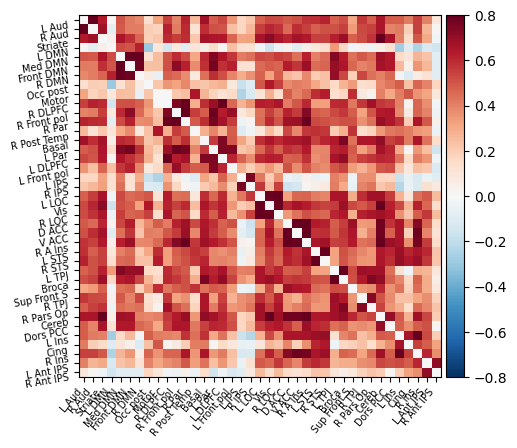

In [11]:
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True)

Or view it as an embedded connectome:

In [12]:
plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

## Accounting for noise sources

As we've already seen,
maskers also allow us to perform other useful operations beyond just masking our data.
One important processing step is correcting for measured signals of no interest (e.g., head motion).
Our `development_dataset` also includes several of these signals of no interest that were generated during fMRIPrep pre-processing.
We can access these with the `confounds` attribute,
using `development_dataset.confounds`.

Let's quickly check what these look like for our first participant:

In [13]:
import pandas as pd

pd.read_table(development_dataset.confounds[0]).head()

trans_x   trans_y   trans_z     rot_x     rot_y  rot_z  \
0  0.000000  0.000000  0.000000  0.000000 -0.000000    0.0   
1  0.002290  0.039488 -0.000004  0.000000  0.000190    0.0   
2 -0.000011 -0.104030 -0.009560  0.000164  0.000366    0.0   
3 -0.000031  0.169104  0.013041 -0.000843  0.000453    0.0   
4 -0.000061 -0.145348 -0.025025  0.000060  0.000386    0.0   

   framewise_displacement  a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  \
0                0.000000       0.000000       0.000000       0.000000   
1                0.051301      -0.009419       0.064324      -0.046474   
2                0.172322      -0.013124       0.010970       0.072557   
3                0.350465       0.033150       0.025784       0.036211   
4                0.401084      -0.035600      -0.035397      -0.127860   

   a_comp_cor_03  a_comp_cor_04  a_comp_cor_05         csf  white_matter  
0       0.000000       0.000000       0.000000  525.521464    473.476960  
1       0.006744      -0.007179       0.025285  529.577966    476.734232  
2       0.030795       0.015773      -0.063280  531.250261    476.517911  
3       0.005530       0.048968      -0.025824  531.240585    476.460569  
4       0.001092      -0.031902       0.048258  531.931781    476.174483

We can see that there are several different kinds of noise sources included!
This is actually a subset of all possible fMRIPrep generated confounds that the Nilearn developers have pre-selected.
We could access the full list by passing the argument `reduce_confounds=False` to our original call downloading the `development_dataset`.
For most analyses, this list of confounds is reasonable, so we'll use these Nilearn provided defaults.
For your own analyses, make sure to check which confounds you're using!

Importantly, we can pass these confounds directly to our masker object:

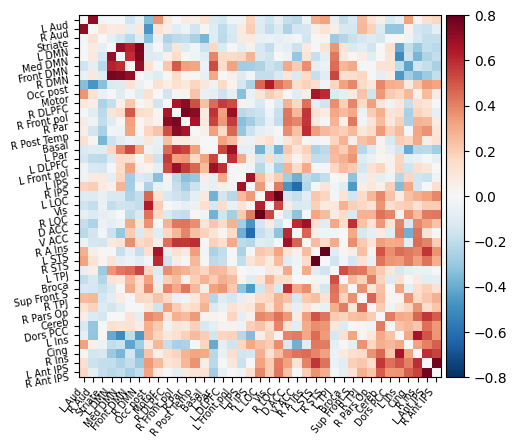

In [14]:
corrected_roi_time_series = masker.transform(
    development_dataset.func[0], confounds=development_dataset.confounds[0])
corrected_correlation_matrix = correlation_measure.fit_transform(
    [corrected_roi_time_series])[0]
np.fill_diagonal(corrected_correlation_matrix, 0)
plotting.plot_matrix(corrected_correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True)

As before, we can also view this functional connectivity matrix as a connectome:

In [15]:
plotting.view_connectome(corrected_correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

In both the matrix and connectome forms,
we can see a big difference when including the confounds!
This is an important reminder to make sure that your data are cleaned of any possible sources of noise _before_ running a machine learning analysis.
Otherwise, you might be classifying participants on e.g. amount of head motion rather than a feature of interest!

```{bibliography} references.bib
:style: unsrt
:filter: docname in docnames
```